In [ ]:
import pandas as pd
import numpy as np
import ast
import tensorflow_hub as hub
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_location = "/content/drive/MyDrive/395 Senior Project/Dataset/modern_feature_films.csv"

Reducing the dataset to include modern films (any film released after 1/1/1900) and feature films (defined as any film longer than 40 minutes long).

In [ ]:
modern_films = data[data['release_date'] > pd.to_datetime('1900-01-01')]

In [ ]:
modern_feature_films = modern_films[modern_films['runtime'] > 40]

In [ ]:
modern_feature_films = modern_feature_films.dropna(subset=['imdb_id'])

In [ ]:
backup = pd.read_csv(file_location)

In [ ]:
modern_feature_films = backup.copy()

In [ ]:
modern_feature_films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314210 entries, 0 to 314209
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1          314210 non-null  int64  
 1   Unnamed: 0            314210 non-null  int64  
 2   id                    314210 non-null  int64  
 3   title                 314210 non-null  object 
 4   vote_average          206475 non-null  float64
 5   vote_count            314210 non-null  int64  
 6   release_date          314210 non-null  object 
 7   revenue               314210 non-null  int64  
 8   runtime               314210 non-null  float64
 9   adult                 314210 non-null  bool   
 10  budget                314210 non-null  int64  
 11  imdb_id               314210 non-null  object 
 12  original_language     314210 non-null  object 
 13  original_title        314210 non-null  object 
 14  overview              301607 non-null  object 
 15  

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/395 Senior Project/Dataset/183_keywords.xlsx")

### `genres`

In [ ]:
working_df = df.copy()

In [ ]:
working_df['genres'] = working_df['genres'].str.lower()

# Split the genres by comma and strip any leading/trailing whitespace
working_df['genres'] = working_df['genres'].apply(
    lambda x: [genre.strip() for genre in x.split(',')]
    if isinstance(x, str) else x)

all_genres = working_df['genres'].explode()

unique_genres = all_genres.unique().tolist()


In [ ]:
# Remove the nan
unique_genres.pop(19)

nan

In [ ]:
unique_genres

['action',
 'science fiction',
 'adventure',
 'drama',
 'crime',
 'thriller',
 'fantasy',
 'comedy',
 'romance',
 'western',
 'mystery',
 'war',
 'animation',
 'family',
 'horror',
 'music',
 'history',
 'tv movie',
 'documentary']

## NLP (actual)

### Mapping genres to coordinate values

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embeddings = embed(unique_genres)

#reduce to 2 dimension
pca = PCA(n_components=2)
mappings = pca.fit_transform(embeddings)

# Map genres to their corresponding 1D values
vectorized_genres = {genre: value for genre, value in zip(unique_genres, mappings)}

In [ ]:
vectorized_genres

{'action': array([ 0.10503006, -0.22630377]),
 'science fiction': array([-0.11281167, -0.01321406]),
 'adventure': array([ 0.17067921, -0.36141261]),
 'drama': array([-0.17215427, -0.07987447]),
 'crime': array([ 0.10070013, -0.23088262]),
 'thriller': array([-0.57886115,  0.18796826]),
 'fantasy': array([ 0.01876107, -0.23833051]),
 'comedy': array([-0.33968406, -0.05171436]),
 'romance': array([-0.09730741, -0.2550092 ]),
 'western': array([0.5336787 , 0.13133064]),
 'mystery': array([-0.14818018, -0.16440032]),
 'war': array([ 0.22405637, -0.21513898]),
 'animation': array([0.19989002, 0.1948903 ]),
 'family': array([0.33142904, 0.02066005]),
 'horror': array([-0.44614309, -0.13423493]),
 'music': array([0.01276481, 0.2763254 ]),
 'history': array([0.17583651, 0.0293499 ]),
 'tv movie': array([-0.08154874,  0.61285358]),
 'documentary': array([0.10386463, 0.51713769])}

In [ ]:
converted_genres = {key: value.tolist() for key, value in vectorized_genres.items()}

In [ ]:
converted_genres

{'action': [0.10503006352000731, -0.22630376616776185],
 'science fiction': [-0.1128116689904679, -0.0132140575303782],
 'adventure': [0.17067921370600247, -0.3614126103799646],
 'drama': [-0.17215426774430792, -0.07987446932023397],
 'crime': [0.10070013419584972, -0.23088261857051148],
 'thriller': [-0.5788611540999842, 0.18796826055869575],
 'fantasy': [0.018761070911079463, -0.23833051286038892],
 'comedy': [-0.3396840601297845, -0.051714355216244436],
 'romance': [-0.09730740600241963, -0.2550091968930574],
 'western': [0.5336787021966296, 0.1313306400353549],
 'mystery': [-0.14818018073985786, -0.16440032476480063],
 'war': [0.22405637287143976, -0.21513898295049574],
 'animation': [0.19989002120446991, 0.1948902967303665],
 'family': [0.33142904270141993, 0.020660053148039502],
 'horror': [-0.44614309379794825, -0.13423493259040176],
 'music': [0.01276480761915299, 0.276325404453158],
 'history': [0.17583651393774374, 0.02934990234115782],
 'tv movie': [-0.08154873964181353, 0.6

In [ ]:
genres = list(converted_genres.keys())
x_coords = [coords[0] for coords in converted_genres.values()]
y_coords = [coords[1] for coords in converted_genres.values()]

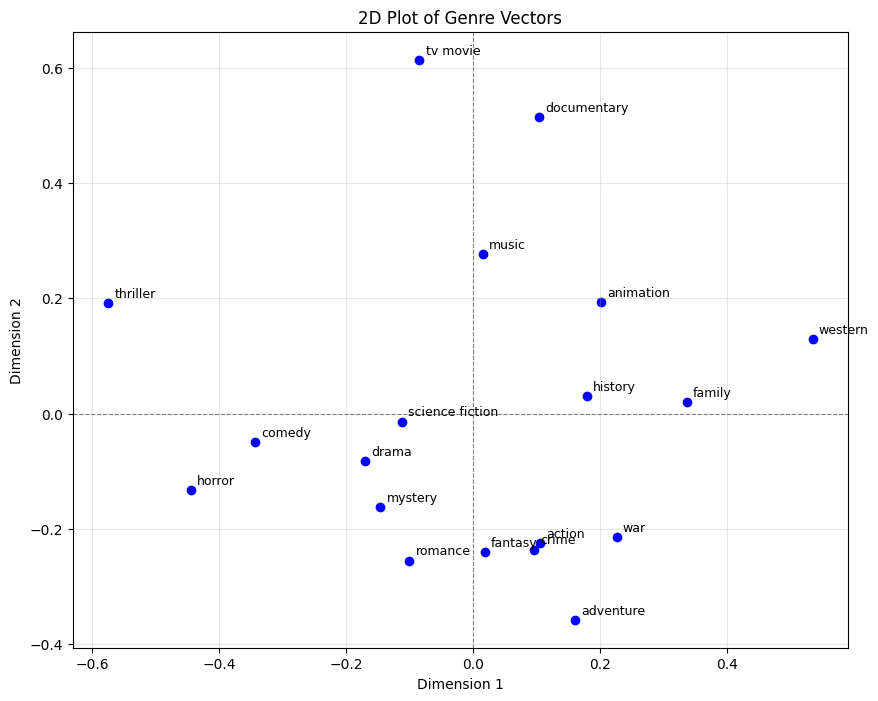

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, color='blue')

for genre, x, y in zip(genres, x_coords, y_coords):
    plt.text(x + 0.01, y + 0.01, genre, fontsize=9)

plt.title('2D Plot of Genre Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.axvline(0, color='grey', linewidth=0.8, linestyle='--')
plt.grid(alpha=0.3)
plt.show()

### Vectorizing each movie's list of genres

In [ ]:
vectorirzed_df = working_df.copy()

In [ ]:
# Update the genres column using converted_genres
vectorirzed_df['combined_genres'] = vectorirzed_df['genres'].apply(
    lambda genre_list: [converted_genres[genre] for genre in genre_list] if isinstance(genre_list, list) else genre_list
)


In [ ]:
vectorirzed_df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,...,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,combined_genres
0,0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"[action, science fiction, adventure]","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...","[[0.10503006352000731, -0.22630376616776185], ..."
1,1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,...,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"[adventure, drama, science fiction]","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...","[[0.17067921370600247, -0.3614126103799646], [..."
2,2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"[drama, action, crime, thriller]","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...","[[-0.17215426774430792, -0.07987446932023397],..."
3,3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"[action, adventure, fantasy, science fiction]","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...","[[0.10503006352000731, -0.22630376616776185], ..."
4,4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"[science fiction, action, adventure]",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...","[[-0.1128116689904679, -0.0132140575303782], [..."


In [ ]:
vectorirzed_df.to_csv("/content/drive/MyDrive/395 Senior Project/Dataset/183_vec_genre.csv")

In [ ]:
twod_genre = vectorirzed_df.copy()

In [ ]:
no_null = twod_genre.dropna(subset=['genres'], inplace=False)

In [ ]:
def combine_genres(genres):
    genres_2d = np.array(genres)

    # Compute the mean of x and y values
    avg_x = np.mean(genres_2d[:, 0])
    avg_y = np.mean(genres_2d[:, 1])

    return [avg_x, avg_y]

In [ ]:
no_null['combined_genres'] = no_null['combined_genres'].apply(combine_genres)

<ipython-input-22-6e526714b52b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_null['combined_genres'] = no_null['combined_genres'].apply(combine_genres)


In [ ]:
no_null.head()

,Unnamed: 0.1,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,...,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,combined_genres
0,0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"[action, science fiction, adventure]","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...","[0.05429920274518063, -0.20031014469270156]"
1,1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,...,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"[adventure, drama, science fiction]","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...","[-0.03809557434292445, -0.1515003790768589]"
2,2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"[drama, action, crime, thriller]","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...","[-0.13632130603210876, -0.0872731483749529]"
3,3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"[action, adventure, fantasy, science fiction]","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...","[0.04541466978665534, -0.2098152367346234]"
4,4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"[science fiction, action, adventure]",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...","[0.05429920274518063, -0.20031014469270156]"


In [ ]:
overview_working = no_null.dropna(subset=['overview'], inplace=False)

In [ ]:
overview_working

,Unnamed: 0.1,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,...,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,combined_genres
0,0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"[action, science fiction, adventure]","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...","[0.05429920274518063, -0.20031014469270156]"
1,1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,...,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"[adventure, drama, science fiction]","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...","[-0.03809557434292445, -0.1515003790768589]"
2,2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"[drama, action, crime, thriller]","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...","[-0.13632130603210876, -0.0872731483749529]"
3,3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"[action, adventure, fantasy, science fiction]","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...","[0.04541466978665534, -0.2098152367346234]"
4,4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"[science fiction, action, adventure]",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...","[0.05429920274518063, -0.20031014469270156]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314202,832765,1104348,717277,Signs,NaN,0,2013-12-12,0,80,False,...,Isyarat,'Isyarat' takes the innovative approach of bri...,0.844,They see things that we don't,"[drama, thriller, mystery]",Lingkar Alumni Indie Movie,NaN,Indonesian,NaN,"[-0.29973186752805, -0.018768844508779612]"
314203,832783,1104368,717273,The Widow's Might,NaN,0,1918-01-28,0,50,False,...,The Widow's Might,"Dick Tavish, a young New Yorker, decides that ...",0.710,NaN,"[comedy, drama]",NaN,NaN,NaN,eurospy,"[-0.2559191639370462, -0.0657944122682392]"
314204,832797,1104385,717260,Shouting at the Wind,NaN,0,2018-12-19,0,62,False,...,Faryad Roo Be Baad,"Meysam, an adolescent from Tehran’s roughest n...",0.600,NaN,[documentary],NaN,Iran,Persian,NaN,"[0.103864628282789, 0.5171376946278301]"
314206,832821,1104412,717382,Borderline,NaN,0,1988-01-01,0,120,False,...,Borderline,Story about a young pianist accused of murderi...,0.676,Guilty?,[drama],Epo-Film,Austria,German,NaN,"[-0.17215426774430792, -0.07987446932023397]"


In [ ]:
def encode_overview(overview):
    if isinstance(overview, str):
        return embed([overview]).numpy()[0]

In [ ]:
overview_working['embedded_overview'] = overview_working['overview'].apply(encode_overview)

<ipython-input-27-177565d2adcd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overview_working['embedded_overview'] = overview_working['overview'].apply(encode_overview)


In [ ]:
embedding_matrix = np.stack(overview_working['embedded_overview'].values)

In [ ]:
pca = PCA(n_components=100)

In [ ]:
reduced_embeddings = pca.fit_transform(embedding_matrix)

In [ ]:
overview_working['embedded_overview'] = list(reduced_embeddings)

<ipython-input-31-301d70b7c96c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overview_working['embedded_overview'] = list(reduced_embeddings)


In [ ]:
keys = overview_working.copy()

In [ ]:
keys['keywords'] = keys['keywords'].str.lower()

# Split the genres by comma and strip any leading/trailing whitespace
keys['keywords'] = keys['keywords'].apply(lambda x: [key.strip() for key in x.split(',')] if isinstance(x, str) else x)

all_keys = keys['keywords'].explode()

unique_keys = all_keys.unique().tolist()


Exception ignored in: <function ZipFile.__del__ at 0x7aa782b528c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


In [ ]:
len(unique_keys)

49788

In [ ]:
test = keys.copy()
test['keywords'] = keys['keywords'].dropna()
list_lengths = test['keywords'].dropna().apply(len)

avg_length = list_lengths.mean()

In [ ]:
print(avg_length)

4.1412799345750635


In [ ]:
target_type = float
indices = [index for index, item in enumerate(unique_keys) if isinstance(item, target_type)]
indices

[6563]

In [ ]:
unique_keys[6563]

nan

In [ ]:
unique_keys.pop(6563)

nan

In [ ]:
embeddings_keys = embed(unique_keys)

In [ ]:
pca_key = PCA(n_components=4)
mappings = pca_key.fit_transform(embeddings_keys)

# Map genres to their corresponding 4D values
vectorized_keys = {key: value for key, value in zip(unique_keys, mappings)}

In [ ]:
converted_keys = {key: value.tolist() for key, value in vectorized_keys.items()}

In [ ]:
working_keys = keys.copy()

In [ ]:
working_keys['combined_keywords'] = working_keys['keywords'].apply(
    lambda key_list: [converted_keys[key] for key in key_list] if isinstance(key_list, list) else key_list
)


In [ ]:
fourd_keys = working_keys.copy()

In [ ]:
fourd_keys['combined_keywords'] = fourd_keys['combined_keywords'].fillna(0)

In [ ]:
def combine_keys(keys):
  if keys == 0:
    return [0, 0, 0, 0]
  keys_4d = np.array(keys)
  avg_values = np.mean(keys_4d, axis=0)
  return avg_values.tolist()

In [ ]:
fourd_keys['combined_keywords'] = fourd_keys['combined_keywords'].apply(combine_keys)

In [ ]:
fourd_keys['combined_keywords']

,combined_keywords
0,"[0.10666070140459552, 0.005285985846792842, 0...."
1,"[0.04693729888059995, 0.0398580394088417, 0.04..."
2,"[-0.048707715853301546, 0.09678675289309485, 0..."
3,"[0.03329644683367816, 0.010015189572965346, 0...."
4,"[0.026345259554478428, -0.05073259881779638, 0..."
...,...
314202,"[0, 0, 0, 0]"
314203,"[0.364593004045941, -0.013341888590771761, -0...."
314204,"[0, 0, 0, 0]"
314206,"[0, 0, 0, 0]"


In [ ]:
########### CLUSTERING

In [ ]:
cluster_working = fourd_keys.copy()

In [ ]:
overview_points = np.array(cluster_working['embedded_overview'].tolist(), dtype=np.float64)

In [ ]:
num_clusters = 10 # we return the top ten list
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

In [ ]:
cluster_working['overview_cluster'] = kmeans.fit_predict(overview_points)

In [ ]:
genre_points = np.array(cluster_working['combined_genres'].tolist(), dtype=np.float64)

In [ ]:
cluster_working['genre_cluster'] = kmeans.fit_predict(genre_points)

In [ ]:
keywords_points = np.array(cluster_working['combined_keywords'].tolist(), dtype=np.float64)

In [ ]:
cluster_working['keyword_cluster'] = kmeans.fit_predict(keywords_points)

In [ ]:
cluster_working.to_csv("/content/drive/MyDrive/395 Senior Project/Dataset/movie_database.csv")

In [ ]:
cluster_working.to_pickle("/content/drive/MyDrive/395 Senior Project/Dataset/movie_pickle.pkl")

In [ ]:
cluster_working.head()

,Unnamed: 0.1,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,...,production_companies,production_countries,spoken_languages,keywords,combined_genres,embedded_overview,combined_keywords,overview_cluster,genre_cluster,keyword_cluster
0,0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148,False,...,"Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","[rescue, mission, dream, airplane, paris, fran...","[0.05429920274518063, -0.20031014469270156]","[0.0009236187, 0.07435533, -0.19195612, -0.020...","[0.10666070140459552, 0.005285985846792842, 0....",4,2,2
1,1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169,False,...,"Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"[rescue, future, spacecraft, race against time...","[-0.03809557434292445, -0.1515003790768589]","[0.1643474, 0.09066084, -0.0048870444, -0.2954...","[0.04693729888059995, 0.0398580394088417, 0.04...",9,0,2
2,2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,False,...,"DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","[joker, sadism, chaos, secret identity, crime ...","[-0.13632130603210876, -0.0872731483749529]","[0.012529895, 0.1529288, -0.33974195, 0.065222...","[-0.048707715853301546, 0.09678675289309485, 0...",4,5,8
3,3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162,False,...,"Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","[future, society, culture clash, space travel,...","[0.04541466978665534, -0.2098152367346234]","[0.0095594525, 0.12724766, -0.13946123, -0.134...","[0.03329644683367816, 0.010015189572965346, 0....",9,2,2
4,4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143,False,...,Marvel Studios,United States of America,"English, Hindi, Russian","[new york city, superhero, shield, based on co...","[0.05429920274518063, -0.20031014469270156]","[0.036552325, 0.09881613, -0.2245693, -0.11613...","[0.026345259554478428, -0.05073259881779638, 0...",9,2,3


In [ ]:
####### SEARCHING

In [ ]:
def find_similar_movies(query_point, k=20):
    query_point = np.array(query_point, dtype=np.float64)

    query_cluster = kmeans.predict([query_point])[0]

    cluster_movies = overview_working[overview_working['cluster'] == query_cluster]

    cluster_movies['distance'] = cluster_movies['embedded_overview'].apply(
        lambda x: euclidean(query_point, x)
    )

    similar_movies = cluster_movies.nsmallest(k, 'distance')
    return similar_movies[['title', 'embedded_overview', 'distance']]

In [ ]:
Inception = overview_working[overview_working['title'] == "Inception"].iloc[0]['embedded_overview']

In [ ]:
Hacksaw_Ridge = overview_working[overview_working['title'] == "Hacksaw Ridge"].iloc[0]['embedded_overview']

In [ ]:
hacksaw_input = Hacksaw_Ridge.tolist()

In [ ]:
similar_hacksaw = find_similar_movies(hacksaw_input)

<ipython-input-68-97e48458067a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_movies['distance'] = cluster_movies['embedded_overview'].apply(


In [ ]:
print(similar_hacksaw)

                                                    title  \
166                                         Hacksaw Ridge   
2552                                 Flags of Our Fathers   
242938                                      Baltic Spirit   
301919                                    Going for Broke   
208708            From Mexico to Vietnam: a Chicano story   
7386                                The Last Full Measure   
71769                          The Conscientious Objector   
204041             442: Live with Honor, Die with Dignity   
290218                                 Most Honorable Son   
24142                                Farewell to the King   
227275  761st Tank Battalion: The Original Black Panthers   
81906                                   The Iron Triangle   
39778                                They Came to Cordura   
299058                                     Honor Deferred   
276615                                                Ike   
87390                   

In [ ]:
overview_working.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301607 entries, 0 to 314209
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1          301607 non-null  int64  
 1   Unnamed: 0            301607 non-null  int64  
 2   id                    301607 non-null  int64  
 3   title                 301607 non-null  object 
 4   vote_average          200552 non-null  float64
 5   vote_count            301607 non-null  int64  
 6   release_date          301607 non-null  object 
 7   revenue               301607 non-null  int64  
 8   runtime               301607 non-null  float64
 9   adult                 301607 non-null  bool   
 10  budget                301607 non-null  int64  
 11  imdb_id               301607 non-null  object 
 12  original_language     301607 non-null  object 
 13  original_title        301607 non-null  object 
 14  overview              301607 non-null  object 
 15  popul

### Dimensionality reduction

In [ ]:
non_null = vectorirzed_df[vectorirzed_df['genres'].notnull()]

# Find the length of the genres list for each movie
non_null['num_genres'] = non_null['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)

max_genres = non_null['num_genres'].max()
min_genres = non_null['num_genres'].min()

print(f"Max number of genres: {max_genres}")
print(f"Min number of genres: {min_genres}")

Max number of genres: 11
Min number of genres: 1


<ipython-input-22-cfd7dd0bf5c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null['num_genres'] = non_null['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [ ]:
# Using a Set Transformer instead of sklearn's PCA because PCA requires all
# input vectors to be in the same dimensions.
# I don't want to pad the genre vectors, as I think it's unnecessary within
# the context using genres as the similarity measure.
class SetTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=16, num_heads=4, hidden_dim=128):
        super(SetTransformer, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.pool = nn.Linear(embed_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      x = self.embed(x)  # Shape: [batch_size, embed_dim]
      x = x.unsqueeze(0)  # Add seq_length dimension, making shape [1, batch_size, embed_dim]
      x = x.transpose(0, 1)  # Shape: [seq_length, batch_size, embed_dim]
      attn_output, _ = self.self_attention(x, x, x)  # Attention mechanism
      pooled_output = torch.mean(attn_output, dim=0)  # Mean pooling across the sequence
      output = self.output_layer(self.pool(pooled_output))  # Final output
      return output

In [ ]:
def dimension_reduction(genres):
    genre_tensor = torch.tensor(genres, dtype=torch.float).unsqueeze(1)
    return set_transformer(genre_tensor).detach().numpy()

In [ ]:
# Parameters
input_dim = 1  # Genres in 1d space
embed_dim = 16
num_heads = 4
output_dim = min_genres

set_transformer = SetTransformer(input_dim=input_dim, output_dim=output_dim, embed_dim=embed_dim, num_heads=num_heads)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
vectorirzed_df['reduced_genre_vectors'] = vectorirzed_df['genres'].apply(lambda genres: dimension_reduction(eval(genres)))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## NLP testing


In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
!pip install https://github.com/MartinoMensio/spacy-universal-sentence-encoder/releases/download/v0.4.6/en_use_lg-0.4.6.tar.gz#en_use_lg-0.4.6

In [ ]:
import spacy
import spacy_universal_sentence_encoder

In [ ]:
!pip install spacy spacy-universal-sentence-encoder

In [ ]:
nlp = spacy.load('en_use_lg')

In [ ]:
doc_1 = nlp('Hi there, how are you?')
print(doc_1.vector.shape) # the full document representation

In [ ]:
doc_2 = nlp('What\'s up?')

In [ ]:
print(doc_1.similarity(doc_2[0:7]))

In [ ]:
doc_2.vector

In [ ]:
genres = {"Horror", "Science Fiction", "Action"}

In [ ]:
word_vectors = {genre: nlp(genre).vector for genre in genres}

In [ ]:
len(word_vectors['Action'])

In [ ]:
working_df = modern_feature_films.copy()

In [ ]:
def vectorize(genres):
    return [nlp(genre).vector for genre in genres]

In [ ]:
working_df['genre_vectors'] = working_df['genres'].apply(vectorize)

In [ ]:
# get all the genres that exist in our list of movies
# get the max number of genres that a movie can have (basically whatever movie
# has the max)
# this max is the number of dimensions we work in

# for each movie, convert the list of genres to a list of vectors
